In [2]:
# import the necessary packages
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [5]:
# get image as its raw pixels in grayscale
im_path = "40.jpg"
im = Image.open(im_path).convert("L") 
width, height = im.size

px = np.array(im, dtype=np.float32)

# display some pixel data
px[1,:10]

array([63., 66., 69., 71., 70., 69., 67., 66., 62., 60.], dtype=float32)

To calculate an image's Histogram of Oriented Gradients (HOG), we need each pixel's gradient and angle. we will calculate this using vectorized numpy operations below.

We have also provided the naive implementation, to better show the algorithms' process.

In [6]:
# calculate gradients
gradients = np.ndarray((height,width))

"""
To compute the pixel-wise gradient, we must make two passes over the gradient data.
 One to calculate the horizontal gradient, and one for the vertical. We then combine 
 the two components to find the combined magnitude.

The calculations below take advantage of numpy broadcasting, the naive implementation is also shown
"""
gradient_x = np.zeros_like(px)
gradient_y = np.zeros_like(px)

gradient_x[1:-1, 1:-1] = (-1 * px[1:-1, :-2]) + px[1:-1, 2:]
gradient_y[1:-1, 1:-1] = (-1 * px[0:-2, 1:-1]) + px[2:, 1:-1]

gradients = np.sqrt(gradient_x**2 + gradient_y**2)

# view some gradient data
gradients[1,:10]

array([ 0.       ,  6.3245554,  5.3851647,  1.4142135,  8.246211 ,
       15.297058 , 17.262676 , 17.720045 , 11.661903 ,  3.1622777],
      dtype=float32)

In [9]:
#naive implementation
"""
for i in range(1,height-1):
    for j in range(1,width-1):
        # calculate horizontal and vertical gradient
        # kernel = [-1,0,1]
        grad_horizontal = (-1 * px[i,j-1]) +  (1 * px[i,j+1]) 
        grad_vertical = (-1 * px[i-1,j]) +  (1 * px[i+1,j]) 

        # formulas for getting gradients and angles
        gradients[i,j] = np.sqrt(grad_horizontal**2 + grad_vertical**2)
"""

'\nfor i in range(1,height-1):\n    for j in range(1,width-1):\n        # calculate horizontal and vertical gradient\n        # kernel = [-1,0,1]\n        grad_horizontal = (-1 * px[i,j-1]) +  (1 * px[i,j+1]) \n        grad_vertical = (-1 * px[i-1,j]) +  (1 * px[i+1,j]) \n\n        # formulas for getting gradients and angles\n        gradients[i,j] = np.sqrt(grad_horizontal**2 + grad_vertical**2)\n'

In [10]:
# calculate angles

"""
We have already calculate the X and Y gradient, so to calculate the angle produced from the two components, we just need one more line of code.

Once again, the naive implementation is shown below
"""

angles = np.arctan2(gradient_y,gradient_x)

# view some angle data
angles[1,:10]

array([ 0.        ,  0.32175055,  0.3805064 , -0.7853982 , -1.8157749 ,
       -1.7681918 , -1.7454685 , -1.8568478 , -2.1112158 , -1.2490457 ],
      dtype=float32)

In [ ]:
# naive implementation
"""
for i in range(1,height-1):
    for j in range(1,width-1):
        # calculate horizontal and vertical gradient
        # kernel = [-1,0,1]
        grad_horizontal = (-1 * px[i,j-1]) +  (1 * px[i,j+1]) 
        grad_vertical = (-1 * px[i-1,j]) +  (1 * px[i+1,j]) 
        if grad_horizontal==0:
            angles[i,j] = 3*math.pi/2 if grad_vertical < 0 else math.pi/2
        else:
            angles[i,j] = np.atan(grad_vertical/grad_horizontal)
"""

Lets plot the data, so we can see what is going on.

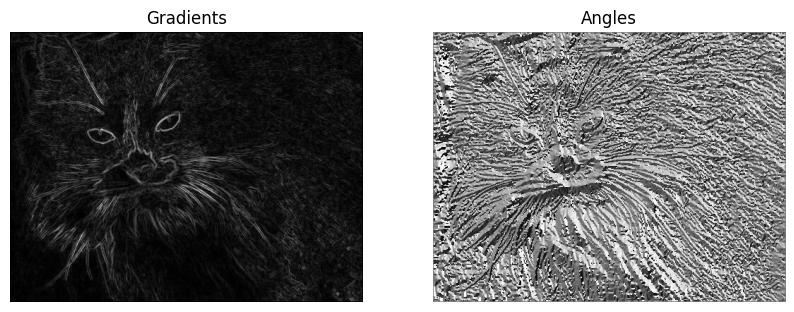

In [11]:
    # plot gradients and angles 
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) 
    axes[0].imshow(gradients, cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("Gradients")
    axes[1].imshow(angles, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title("Angles")
    plt.show()

It appears the gradient data picks up line edges very well. We can also see some relevant data shown in the angles image.

The next step in the algorithm is to split the image into NxM grids of pixels, and compute the actual HOG data for each section. This is shown below. 

Lets start with defining some variables to construct the HOG.

In [12]:
# parameters
num_partitions_x = 30 #split into an X by X grid for calculating hog
num_bins = 10

cell_height = math.ceil(gradients.shape[0] /num_partitions_x)
cell_width = math.ceil(gradients.shape[1] / num_partitions_x)

bins = np.zeros((num_partitions_x,num_partitions_x,num_bins))

to calculate each histogram, we must iterate over every pixel, and place its cooresponding gradient value in the correct bin.

We will once again take advantage of numpy broadcasting to calculate each histogram.

In [13]:
# use numpy again for efficiency
bin_indices = np.floor((num_bins-1) * (angles + np.pi) / (2*np.pi)).astype(int)
partition_x = np.floor(np.arange(gradients.shape[1]) / cell_width).astype(int)
partition_y = np.floor(np.arange(gradients.shape[0])[:, None] / cell_height).astype(int)

np.add.at(bins, (partition_y,partition_x, bin_indices), gradients)

In [ ]:
#naive implementation
"""
for i in range(gradients.shape[0]):
    for j in range(gradients.shape[1]):
        # get the bin index using some algebra
        bin_idx = math.floor(((num_bins-1) * (angles[i][j] + math.pi) / (2*math.pi)))
        bins[i//cell_height,j//cell_width,bin_idx] += gradients[i,j]
"""

And we are done!

The output vector is rather large, so i will just print the beginning 10 values.

In [16]:
bins[1,1,:10]

array([ 114.96763754,  608.32673883, 1301.83567762,  476.70138347,
         22.54668045,   88.74001098,  308.10947633,  197.65001678,
        115.31750202,   16.        ])

What the above data shows is the total amount of gradient inside one cell block that has a certain angle. For a (much) more in depth explanation, visit the wikipedia page.

https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients